# 1.3 Historical Trends

The timeseries plots show a clear seasonality, the function `seasonal_trends` is particularly useful to visually explore the seasonal variations of each variables but also to compare the variation across different years.

In [1]:
from funciones import*
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep="\t")
#Data=pd.read_csv('https://raw.githubusercontent.com/iceclassic/sandbox/main/Data/Time_series_DATA.txt',index_col=0,skiprows=149)
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")

Data = Data[Data.index.year < 2022]

:::{card} Exercise 1

Read the documentation for function `plot_seasonal` and use the function to plot at least one of the columns.
:::

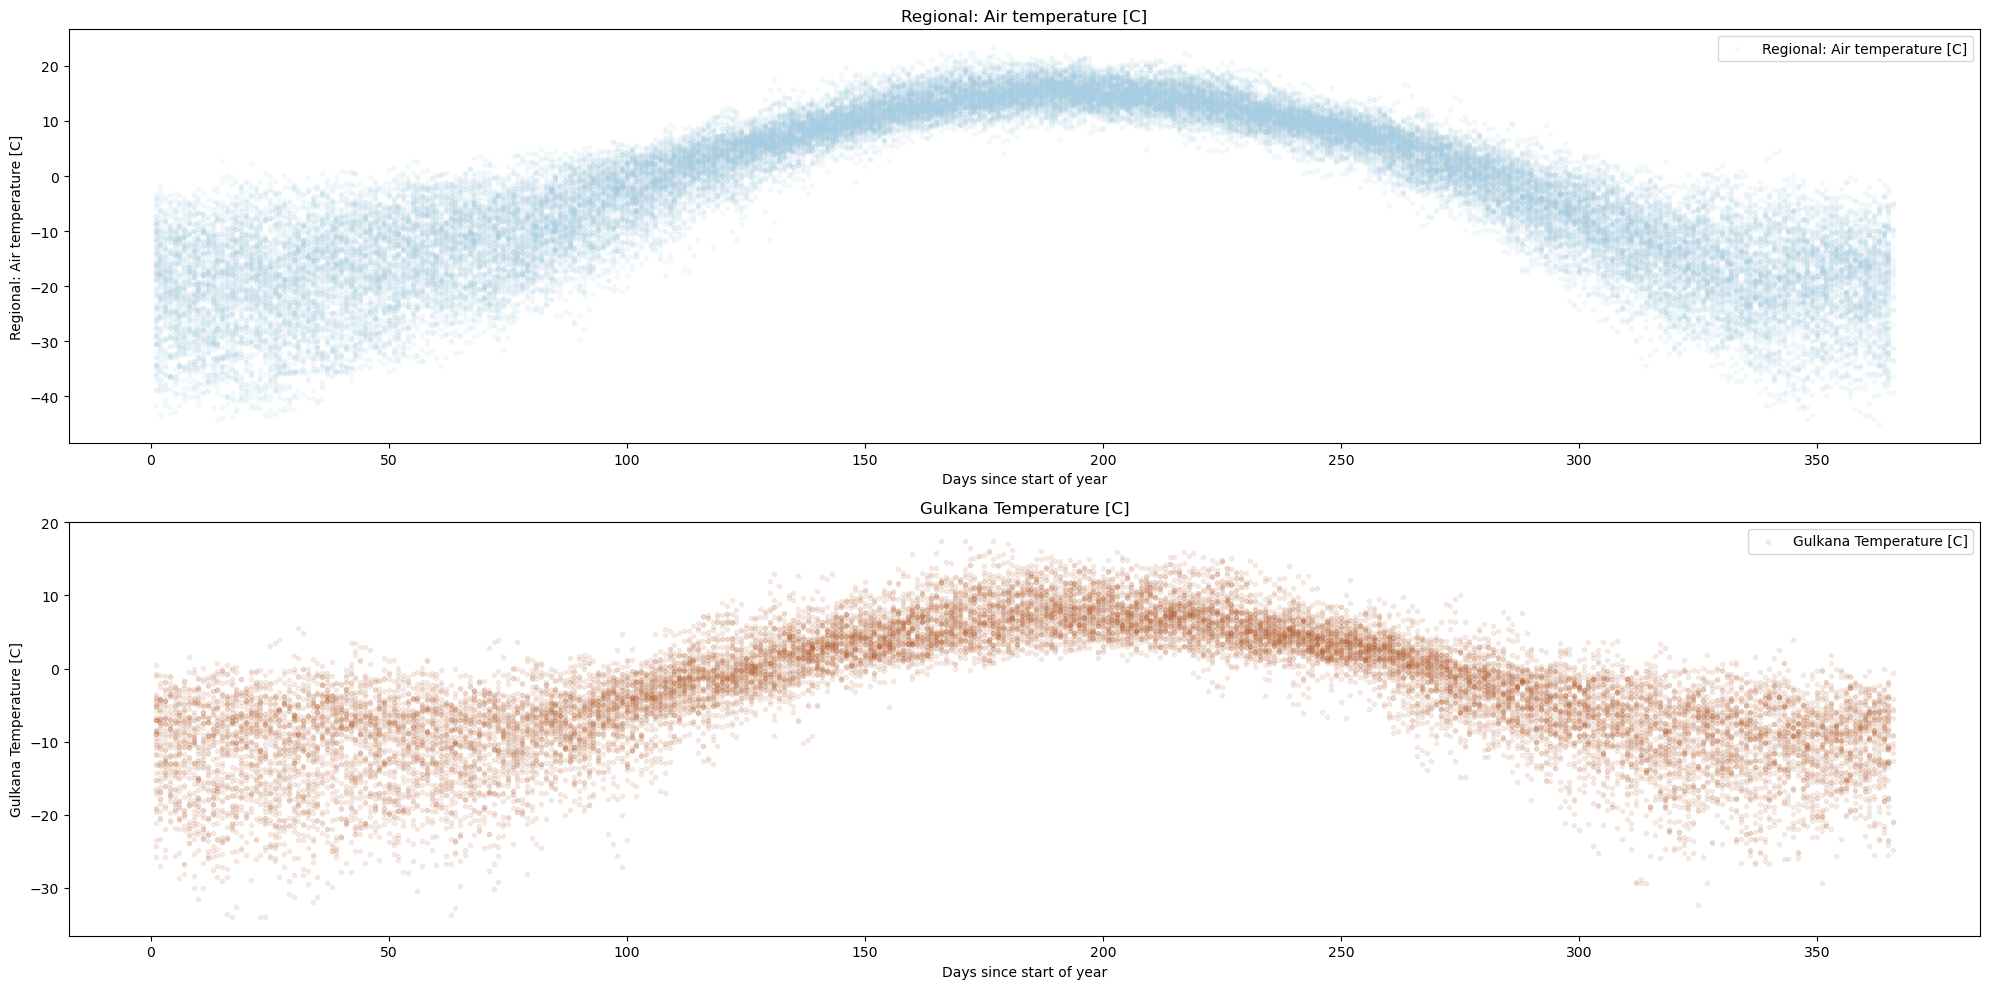

In [2]:
plot_seasonal(Data,columns_to_plot=['Regional: Air temperature [C]','Gulkana Temperature [C]'],col_cmap='Paired')

The previous function can be also use to plot compute the mean and standard deviation of each column.

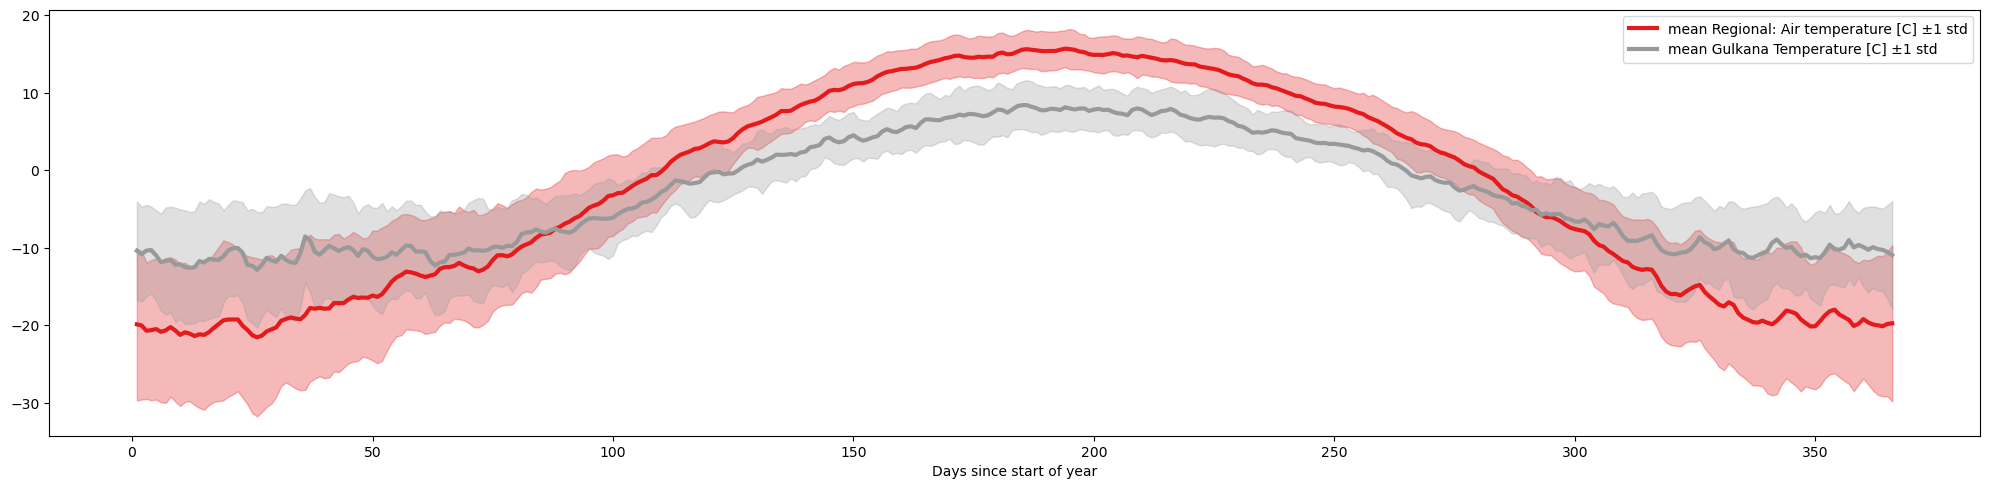

In [3]:
plot_seasonal(Data,columns_to_plot=['Regional: Air temperature [C]','Gulkana Temperature [C]'],plot_together=True,plot_mean_std='only',k=1)

Additionally the function lets us select the data for a set of years and to compare it to the baseline


:::{card} Exercise 3

Use  the argument  `multiyear`  to plot the data corresponding to the last ten years over.

:::

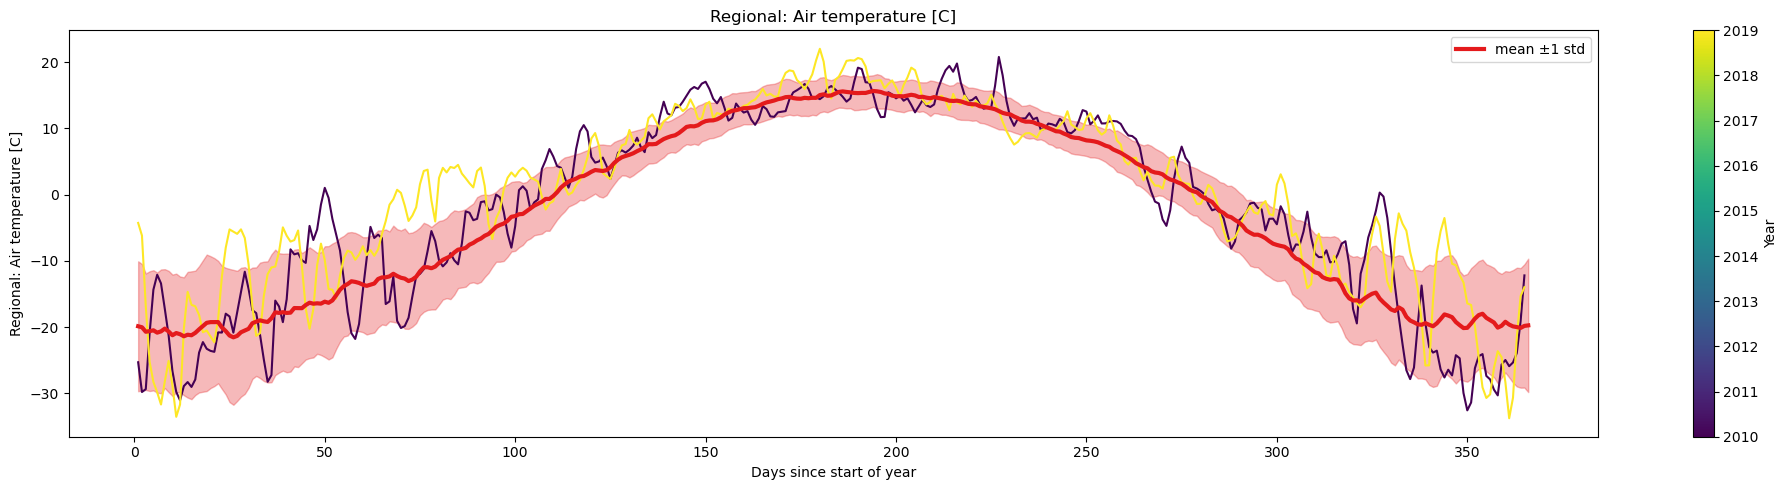

In [4]:
selected_years = [2010,2019]
plot_seasonal(Data,k=1,plot_mean_std='only',multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'])

The function `seasonal_trends()` function primarily extracts the chosen columns for specific days and plots them against another column. By default, this is `xaxis='Days since start of year'`, but any other column can be selected. For instance, setting `xaxis='Days until break-up'` allows us to observe trends leading up to the ice break-up.


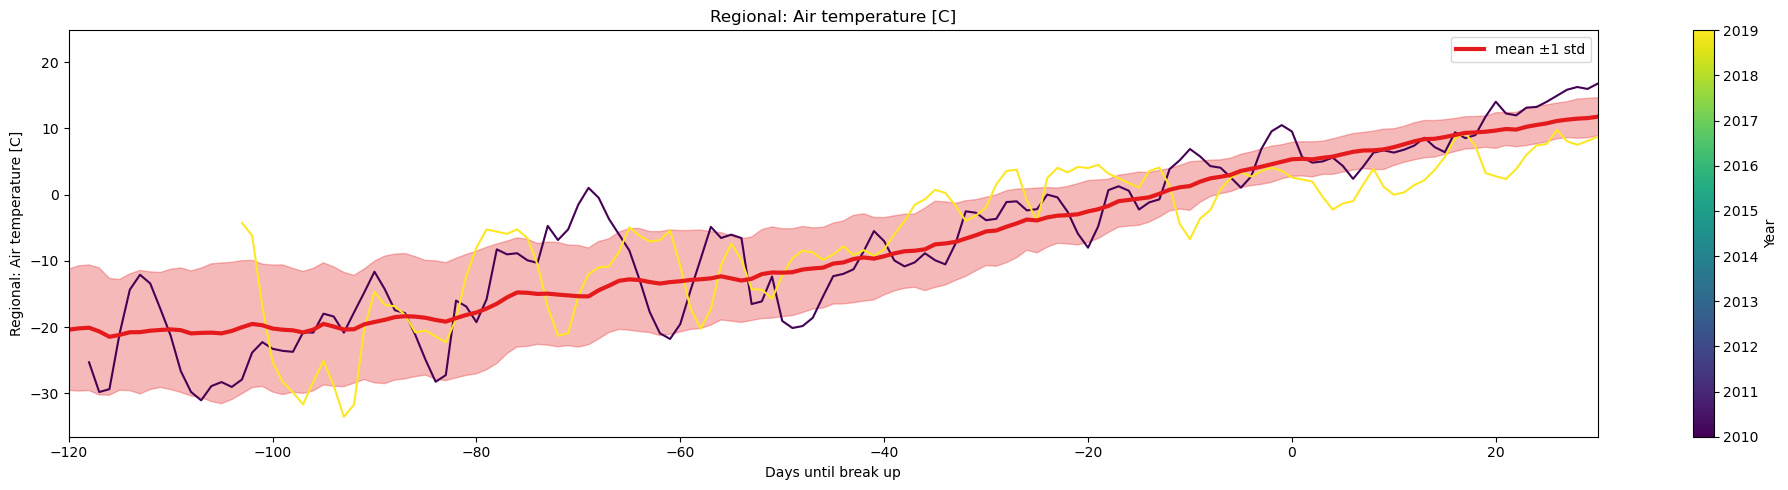

In [5]:
plot_seasonal(Data,multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'],xaxis='Days until break up',xlim=[-120,30],plot_mean_std='only') 

A very simple approach to plot the seasonal variation against others 'x-axis' is to simply create create a new DataFrame , merge it to the original DataFrame and use the previous function.

Alternatively, the function `days_since_last_date` computes, for each date, the number of date since the last occurrence of that date.

:::{card} Exercise 2
Use `days_since_last_date`to plt the variation of the temperature using the number of days since the start of winter as the x-axis
:::

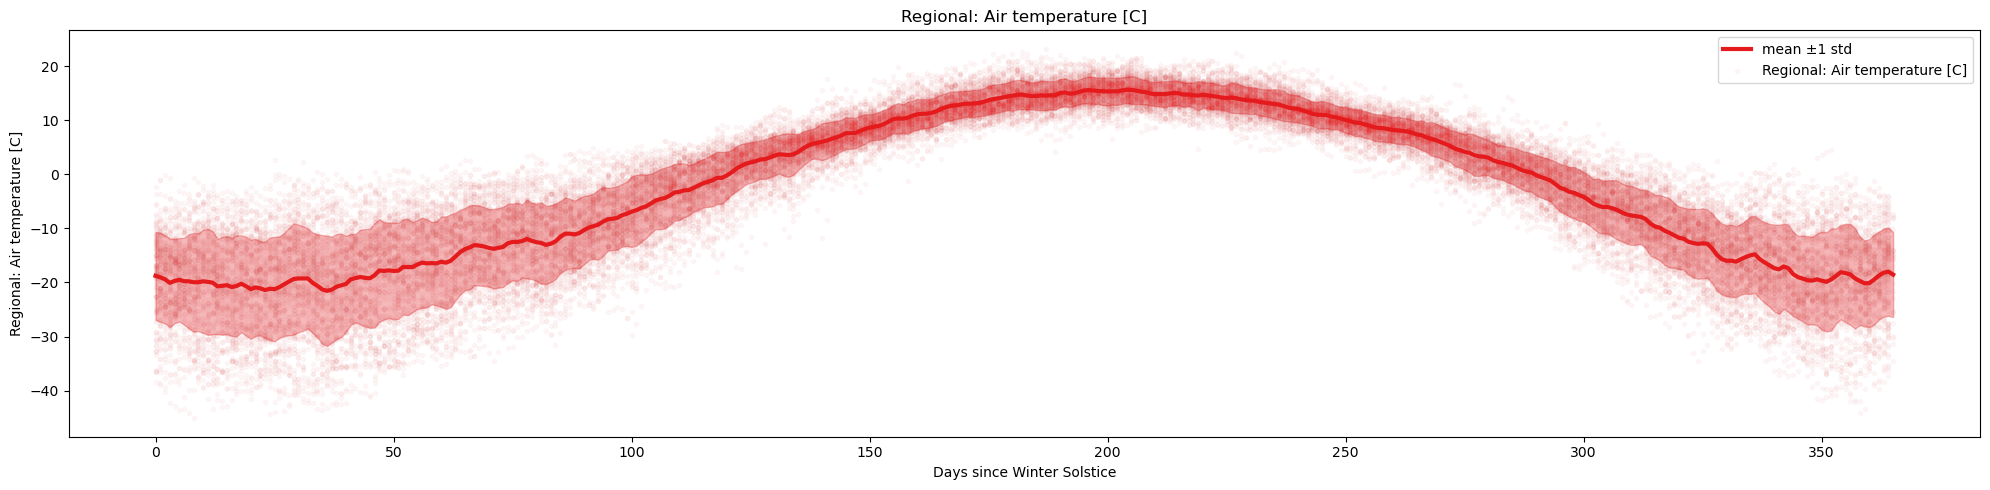

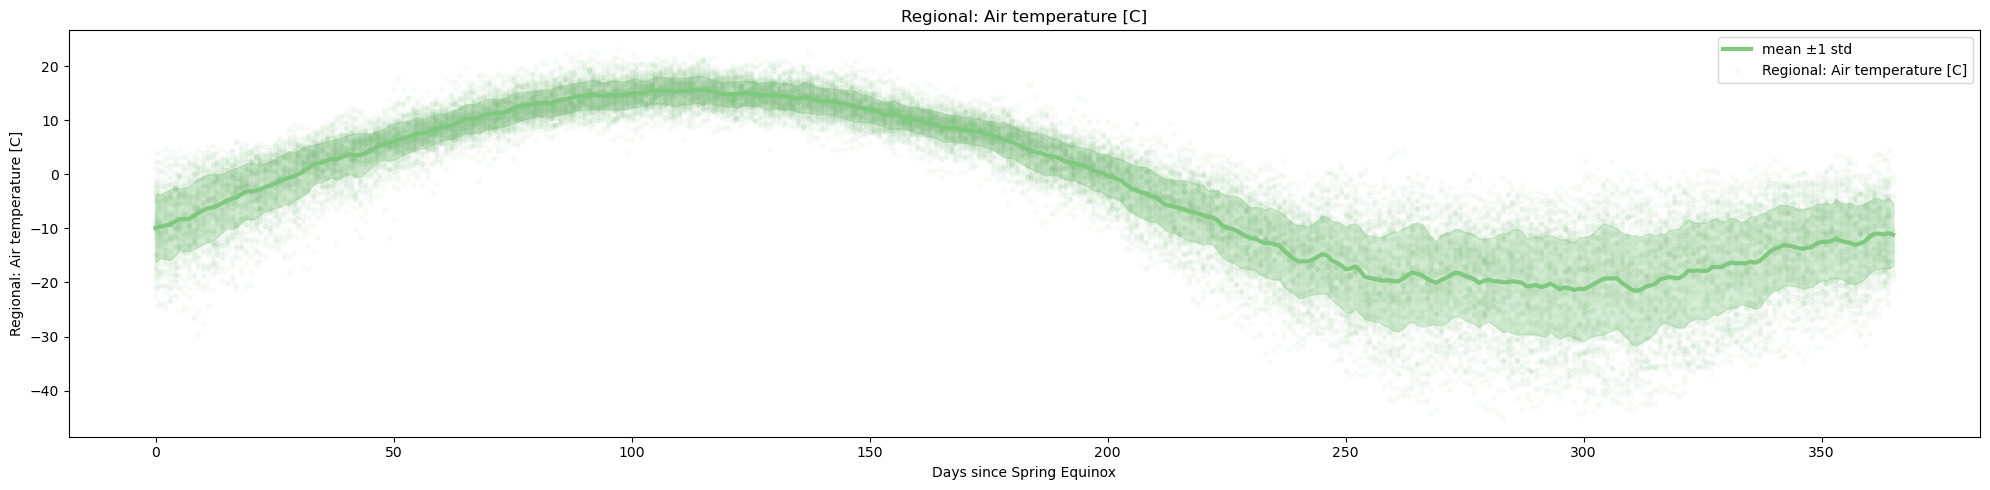

In [6]:
Data=days_since_last_date(Data,date='Winter Solstice')
Data=days_since_last_date(Data,date='Spring Equinox')
plot_seasonal(Data,k=1,plot_mean_std=True,columns_to_plot=['Regional: Air temperature [C]'],xaxis='Winter Solstice',xaxis_name='Days since Winter Solstice',scatter_alpha=0.03)
plot_seasonal(Data,k=1,plot_mean_std=True,columns_to_plot=['Regional: Air temperature [C]'],xaxis='Spring Equinox',xaxis_name='Days since Spring Equinox',col_cmap='Accent',scatter_alpha=0.04)

## Advance filtering:  `groupby`,`transform` and `map` 
By now you should  know how to filter a dataframe to extract rows that have meet a specific conditions, apply logic to this extracted dataframe and then merge this dataframe back into the original.
This sequence of operation is commonly known as *split-apply-combine*, and can be achieved more easily using  built in methods such as `groupby`, `transform` and `map `. 

For example, lets try to re-create the plots above but considering the number of days since the river began to freeze.
Lets define the beginning of freezing as three consecutive day where the mean temperature is below zero.

:::{card}
Re-create the plots but considering, for each winter season, the number of days since the mean daily temperature was under zero for three consecutive days. 
:::




###  Naive Approach
A simple approach would be to loop through each year and then through each day of that years and check wether the temperature is below zero. 
 
:::{card}

The following code  uses a naive approach, looping through each year and then through each day of that yer and evaluation the logic, the code is incomplete, complete it to get a list of the dates when the river start to freeze
:::

In [7]:
t1_0 = time.time()

freezing_dates_1 = []
for year in Data.index.year.unique():                     # Looping through years
    df_year = Data[Data.index.year == year].copy()        # Extracting data for that year
    df_year['Rolling Mean'] = df_year['Regional: Air temperature [C]'].rolling(window=3).mean()  # Compute rolling mean

    Frozen = False  # Initial state
    
    for i in range(3, len(df_year)):                      # Looping through days of that year, starting from day 3
        T_current = df_year.at[df_year.index[i], 'Regional: Air temperature [C]']   # .at is a little bit faster than .loc when extracting a single value from df
        T_rolling_mean = df_year.at[df_year.index[i], 'Rolling Mean']
        T_rolling_mean_prev = df_year.at[df_year.index[i-1], 'Rolling Mean']  # Previous day's rolling mean
        if T_rolling_mean < 0 and T_rolling_mean_prev >= 0:  # Condition for freezing
            Frozen=True
            freezing_dates_1.append(df_year.index[i].strftime('%Y/%m/%d'))

t1_f = time.time()  # Record the end time
delta_t1 = t1_f - t1_0
print(f"Elapsed time: {delta_t1:.4f} seconds")

Elapsed time: 3.5192 seconds


### `groupby`and `transform`
The method [`.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) is used to *split* the dataframe into a group based on some criteria, then the method [`.transform`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html) can be use to apply a functions  to the elements of selected group.

:::{card}
Using the previous methods, extract the list with the date associated with he beginning of freezing.Compare the time needed to extract the list between the naive approach and using the build-in method
:::

In [8]:
t2_0 = time.time()

rolling_avg_below_zero = Data['Regional: Air temperature [C]'].rolling(window=3).mean().lt(0) # method lt is less than and return boolean
Data['starting_to_freeze'] = rolling_avg_below_zero.groupby(Data.index.year).transform(lambda x: x & ~x.shift(1, fill_value=False))

t2_f = time.time()  # Record the end time
delta_t2 = t2_f - t2_0
print(f"Elapsed time: {delta_t2:.4f} seconds")
# extrating the dates to check

Elapsed time: 0.0780 seconds


In the first line, the rolling mean of the temperature  is computed using the method introduce in previously, then the method `.lt` (less than) is used to  assign true/false to each row. 
In the second line, `.groupby` is to use to group the data by year, then `.transform` uses logic to determine wether the condition is met, then the result of the evaluation is added to a column in the dataframe.

As we mentioned before, `.transform` applies a function, if the logic that we need to apply to the elements of the group is simple we can use python's [lambda function](https://docs.python.org/3/reference/expressions.html). 

`lambda `expressions are essentially a temporary, anonymous, function that allows to evaluate an expression in a single line. 


['1917/01/03', '1917/05/06', '1917/10/05', '1917/10/15', '1918/01/01', '1918/04/17', '1918/04/26', '1918/04/30', '1918/10/14', '1919/01/01', '1919/04/12', '1919/10/01', '1919/10/18', '1919/10/29', '1920/01/01', '1920/05/03', '1920/09/25', '1920/10/02', '1921/01/01', '1921/04/14', '1921/04/23', '1921/09/26', '1921/10/03', '1921/10/09', '1921/10/13', '1922/01/01', '1922/04/08', '1922/05/03', '1922/09/25', '1922/10/19', '1923/01/01', '1923/04/09', '1923/04/25', '1923/09/28', '1923/10/17', '1923/10/31', '1924/01/01', '1924/10/07', '1925/01/01', '1925/04/11', '1925/04/26', '1925/10/23', '1926/01/01', '1926/04/04', '1926/10/08', '1926/10/15', '1926/10/25', '1927/01/01', '1927/04/13', '1927/10/05', '1928/01/01', '1928/10/01', '1928/11/06', '1929/01/01', '1929/10/07', '1929/10/13', '1930/01/01', '1930/04/25', '1930/10/02', '1930/10/11', '1931/01/01', '1931/04/30', '1931/10/03', '1931/10/10', '1932/01/01', '1932/04/20', '1932/09/22', '1932/10/01', '1932/10/14', '1933/01/01', '1933/04/15', '1933

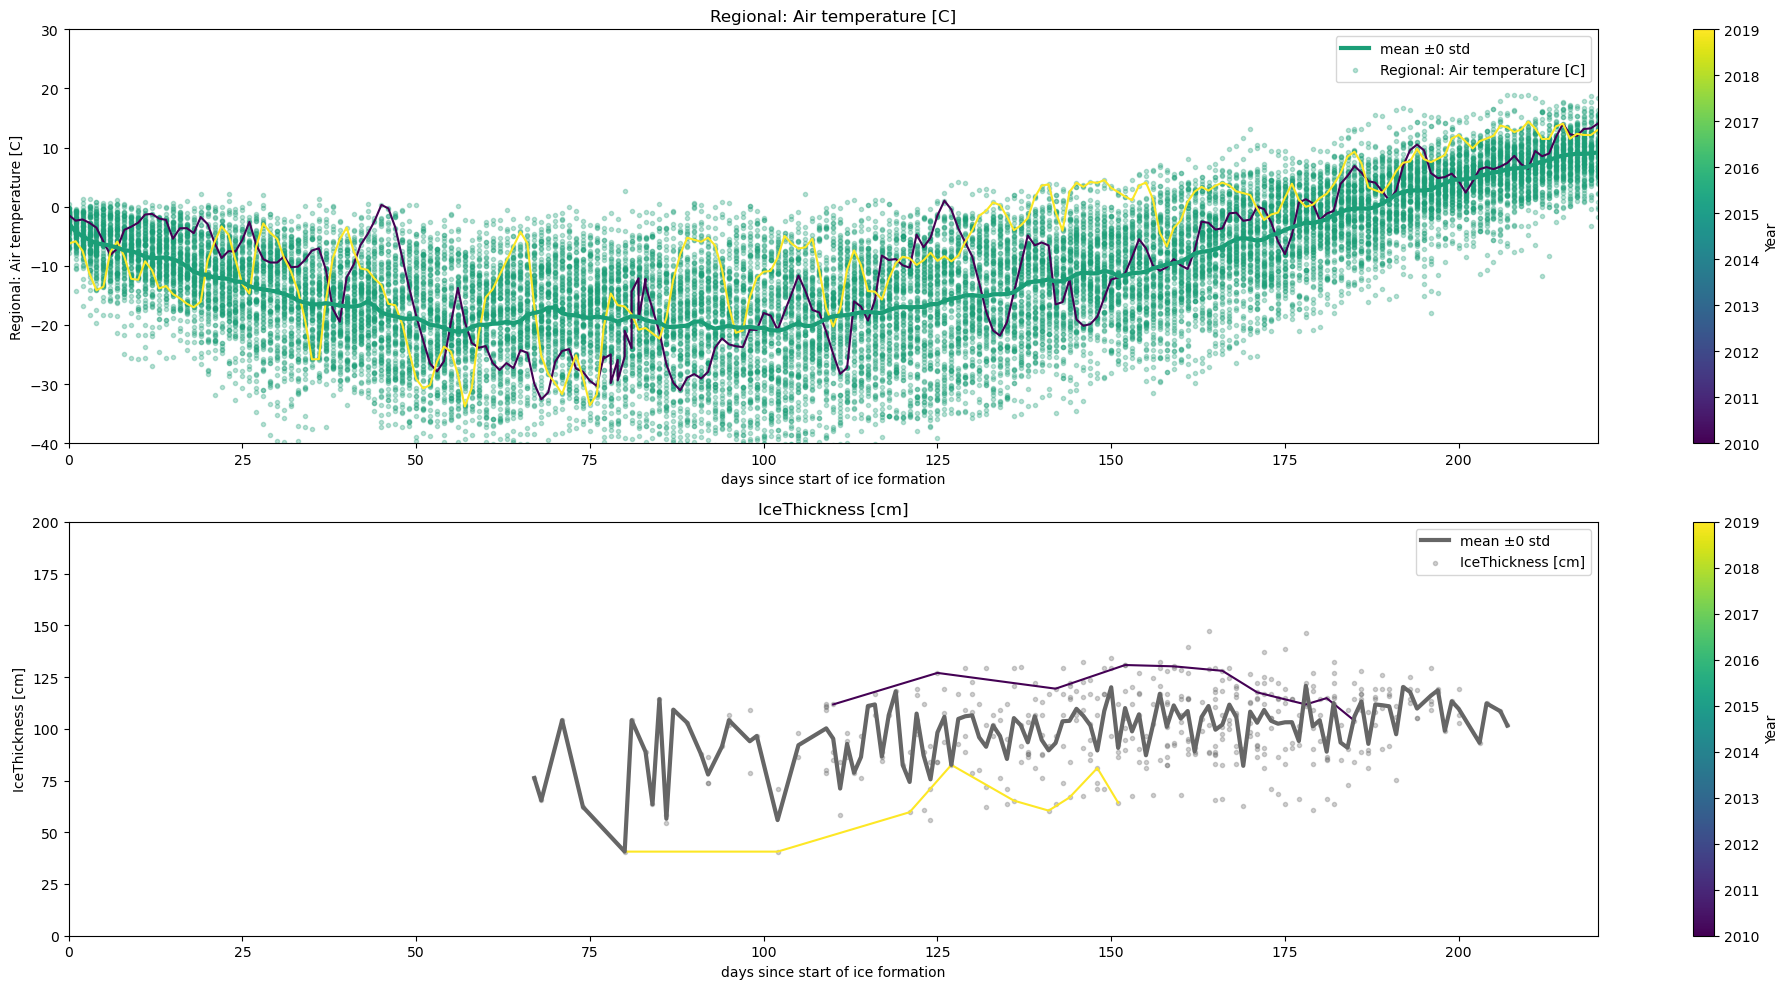

In [13]:

dates_of_occurrences = Data[Data['starting_to_freeze']].index.strftime('%Y/%m/%d').tolist()
print(dates_of_occurrences)

# given the logic used in transfomr, we could have mulitple days of beggining of freezng per year, for exmaple an early cold wave that causes the mean to be  below zero, then
# we assuem that this cold wave are to short to produce any ice, or that the ice formed melts after the cold have has pass, then we care about the last starting to freeze as it 
# correspond to the freezinf period that continues throug the winter 
dates_df = pd.DataFrame(pd.to_datetime(Data[Data['starting_to_freeze']].index.strftime('%Y/%m/%d')), columns=['date'])
dates_df['year'] = dates_df['date'].dt.year
latest_dates_formatted = dates_df.groupby('year')['date'].max().dt.strftime('%Y/%m/%d').tolist()

print(latest_dates_formatted)


Data=days_since_last_date(Data,date=latest_dates_formatted,name='days since start of ice formation')

plot_seasonal(Data,plot_mean_std=True,multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]','IceThickness [cm]'],
              xaxis='days since start of ice formation',scatter_alpha=0.3,col_cmap='Dark2',k=0,xlim=[0,220],ylim=[[-50,30],[0,200]])





filtered_data = Data[Data['first_below_zero']]
dates_of_occurrences = filtered_data.index.strftime('%Y/%m/%d').tolist()
dates_of_occurrences = pd.to_datetime(dates_of_occurrences)
dates_df = pd.DataFrame(dates_of_occurrences, columns=['date'])
dates_df['year'] = dates_df['date'].dt.year
latest_dates = dates_df.groupby('year')['date'].max()
latest_dates_formatted = latest_dates.dt.strftime('%Y/%m/%d').tolist()